In [1]:
!pip install lightgbm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
df = pd.read_csv("BreastDiagnose_dataset.csv")

In [7]:
df.head(2)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN


In [8]:
df = df.rename(columns={'diagnosis':'Label'})

In [9]:
df['Label'].value_counts()

B    357
M    212
Name: Label, dtype: int64

In [10]:
y = df["Label"].values

In [11]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(y) # M=1 and B=0

In [13]:
X = df.drop(labels = ["Label", "id"], axis=1)

In [14]:
feature_names = np.array(X.columns)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)

# https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt',
               #can use gradient decent or random forest or dart for boosting_type,
               #Try dart for better accuracy
              'objective':'binary',#for binary classification
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100,#for not to overfit
              'max_depth':10}

In [18]:
start=datetime.now()
clf = lgb.train(lgbm_params, d_train, 50) #50 iterations.
#Increase iterations for small learning rates as alpha and
#iternations are related
stop=datetime.now()
execution_time_lgbm = stop-start

[LightGBM] [Info] Number of positive: 169, number of negative: 286
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4540
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.371429 -> initscore=-0.526093
[LightGBM] [Info] Start training from score -0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [19]:
#Prediction on test data
y_pred_lgbm=clf.predict(X_test)
#it gives probabilities

In [20]:
#convert into binary values 0/1 for classification
for i in range(0, X_test.shape[0]):
    if y_pred_lgbm[i]>=.5:       # setting threshold to .5
       y_pred_lgbm[i]=1
    else:
       y_pred_lgbm[i]=0

<Axes: >

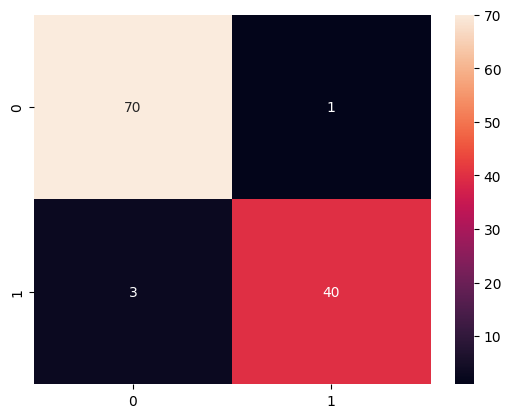

In [21]:
#Confusion matrix

cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm_lgbm, annot=True)

In [22]:
#Print accuracy
print ("Accuracy with LGBM = ", metrics.accuracy_score(y_pred_lgbm,y_test))


Accuracy with LGBM =  0.9649122807017544


In [23]:
print("AUC score with LGBM is: ", roc_auc_score(y_pred_lgbm,y_test))

AUC score with LGBM is:  0.967256932843301


In [24]:
import xgboost as xgb
dtrain=xgb.DMatrix(X_train,label=y_train)


#setting parameters for xgboost
parameters={'max_depth':10,
            'objective':'binary:logistic',
            'eval_metric':'auc',
            'learning_rate':.05}

In [25]:
start = datetime.now()
xg=xgb.train(parameters, dtrain, 50)
stop = datetime.now()

In [26]:
execution_time_xgb = stop-start

In [27]:
#now predicting the model on the test set
dtest=xgb.DMatrix(X_test)
y_pred_xgb = xg.predict(dtest)

<Axes: >

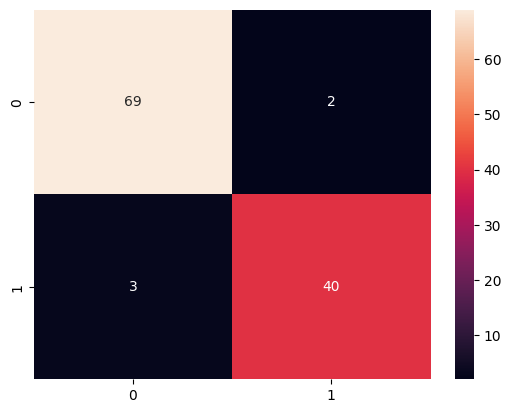

In [28]:
#Converting probabilities into 1 or 0
for i in range(0, X_test.shape[0]):
    if y_pred_xgb[i]>=.5:       # setting threshold to .5
       y_pred_xgb[i]=1
    else:
       y_pred_xgb[i]=0

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True)

In [29]:
print ("Accuracy with XGBoost= ", metrics.accuracy_score(y_pred_xgb, y_test))
print("AUC score with XGBoost is: ", roc_auc_score(y_pred_xgb, y_test))

Accuracy with XGBoost=  0.956140350877193
AUC score with XGBoost is:  0.9553571428571429


In [30]:
print("################################################")
print("LGBM execution time is: ", execution_time_lgbm)
print("XGBoost execution time is: ", execution_time_xgb)
print("################################################")
print ("Accuracy with LGBM = ", metrics.accuracy_score(y_pred_lgbm,y_test))
print ("Accuracy with XGBoost= ", metrics.accuracy_score(y_pred_xgb, y_test))
print("################################################")
print("AUC score with LGBM is: ", roc_auc_score(y_pred_lgbm,y_test))
print("AUC score with XGBoost is: ", roc_auc_score(y_pred_xgb, y_test))

################################################
LGBM execution time is:  0:00:00.136954
XGBoost execution time is:  0:00:00.147980
################################################
Accuracy with LGBM =  0.9649122807017544
Accuracy with XGBoost=  0.956140350877193
################################################
AUC score with LGBM is:  0.967256932843301
AUC score with XGBoost is:  0.9553571428571429
